# Special kursus

## Import of modules

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=f'{0}'

import torch

import datetime
import numpy as np
import matplotlib.pyplot as plt
from hydra import initialize, compose
from scipy import spatial
from scipy.interpolate import LinearNDInterpolator


from modules import torch_util, dataHandler, dataprocessing, plots, models
from modules import scalers as scaling

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")
    print(torch.cuda.current_device())
else:
    print("cpu")
    device = torch.device("cpu")

cpu


## Load data

Loads all the different datasets: Regions, TS profiles, Bathymetri, GHRSST and SMOS.\
The TS profiles also gets cleaned and split into different regions

In [3]:
(
    regions,
    ts_profiles,
    bathymetri_lat, bathymetri_lon, bathymetri_topography,
    ghrsst_lat, ghrsst_lon, ghrsst_sst, ghrsst_times, ghrsst_fraction_time, ghrsst_time_bnds,
    smos_sss, smos_time, smos_lat, smos_lon
) = dataHandler.load_all(verbose=True)

/Users/mehkj/Developer/NEURAL-NETWORK-FOR-ARCTIC-CLIMATE-DATA/modules/dataHandler.py:335: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  bathymetri_topography: np.ndarray = bathymetri['bedrock_topography'][:].data[bathymetri_lat > 60, :]
/Users/mehkj/Developer/NEURAL-NETWORK-FOR-ARCTIC-CLIMATE-DATA/modules/dataHandler.py:335: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  bathymetri_topography: np.ndarray = bathymetri['bedrock_topography'][:].data[bathymetri_lat > 60, :]


In [4]:
ts_areas = dataprocessing.split_regions(ts_profiles, regions.set_crs(4326))

/Users/mehkj/Developer/NEURAL-NETWORK-FOR-ARCTIC-CLIMATE-DATA/modules/dataprocessing.py:24: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  points = gp.GeoDataFrame(ts_profiles.point, columns=['geometry']).set_crs(4326)
/Users/mehkj/Developer/NEURAL-NETWORK-FOR-ARCTIC-CLIMATE-DATA/modules/dataHandler.py:226: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([getattr(profile, __name) for profile in self.profiles], dtype=self.__get_type(out))
/opt/homebrew/Caskroom/miniforge

## Creation of training, validation and testing datasets

The following code splits the dataset into 3 datasets (training, valdiation and testing).\
The data outside the ghrsst time is cut.

In [5]:
min_time, max_time = min(ghrsst_fraction_time), max(ghrsst_fraction_time)
training_end = 2012
validation_end = 2015
train, val, test, areas = dataprocessing.split_data_set(ts_areas, training_end, validation_end, min_time, max_time)

Construct all datasets

In [6]:
scalers = [
    scaling.MeanScaling, # lar
    scaling.MeanScaling, # lon
    scaling.MeanScaling, # year
    scaling.MeanScaling, # decimal year
    scaling.MeanScaling, # sss
    scaling.MeanScaling, # sst
    scaling.MeanScaling, # surface depth
    scaling.MinMaxScaling, # bathymetri
    scaling.MeanScaling, # salinity profile
    scaling.MeanScaling, # temperature profile
]

scalers, train_loader, val_loader, test_loader = dataprocessing.process_data(
    train=train,
    val=val,
    test=test,
    bathymetri_lat=bathymetri_lat,
    bathymetri_lon=bathymetri_lon,
    bathymetri_topography=bathymetri_topography,
    scalers= scalers
)

scaler_names = ['lat', 'lon', 'year', 'decimal_year', 'sss', 'sst', 'depth', 'bathymetri', 'salinity', 'temperatur']
named_scalers = torch_util.Dict(zip(scaler_names, scalers))

## Models

Construct model

In [7]:
with initialize(config_path="./config"):
    cfg = compose(config_name="experiment").experiment

model = models.load_model(train_loader)
print(f"Model type is of type {model.model_type} on {cfg.area}")

# Predictions
y_train_pred, y_train_true = model.predict(train_loader)
y_val_pred, y_val_true = model.predict(val_loader)
y_test_pred, y_test_true = model.predict(test_loader)

# Corresponding depths
train_depth = train[cfg.area].depth
val_depth = val[cfg.area].depth
test_depth = test[cfg.area].depth

Model type is of type Salinity on Beaufort Sea


----------Training----------


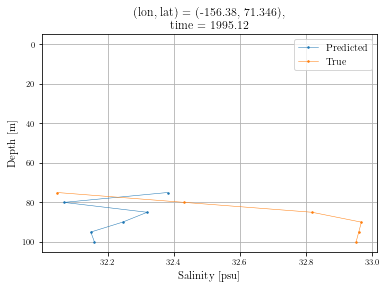

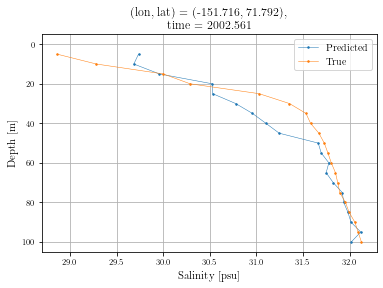

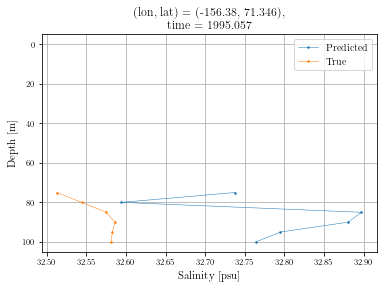

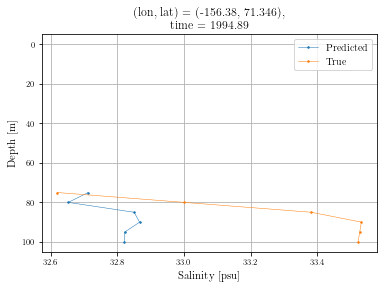

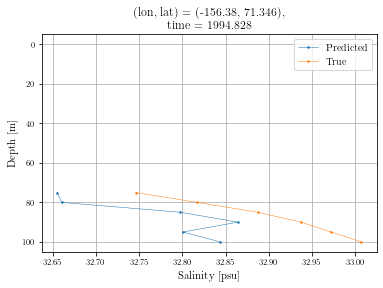

----------Validation----------


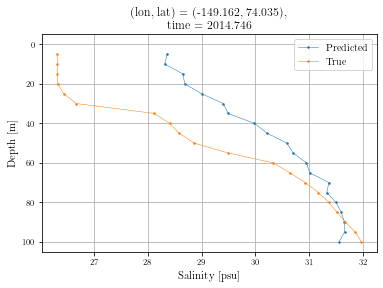

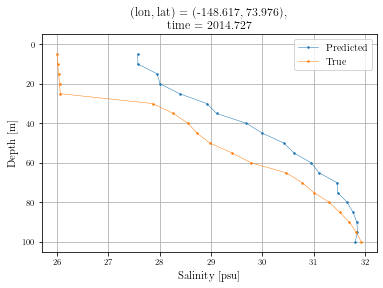

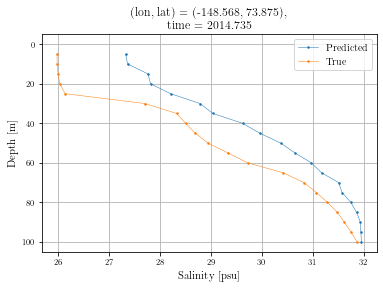

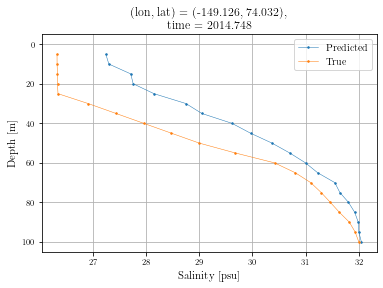

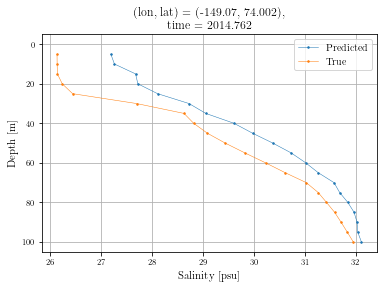

----------Testing----------


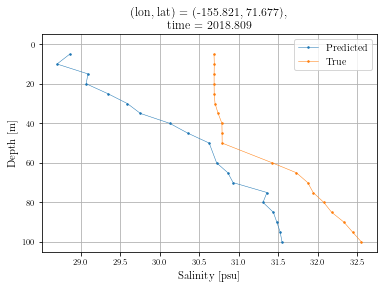

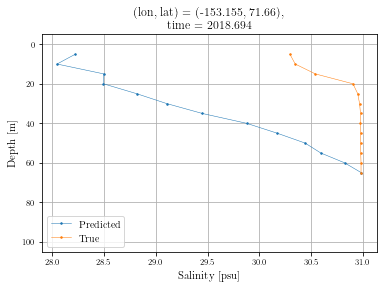

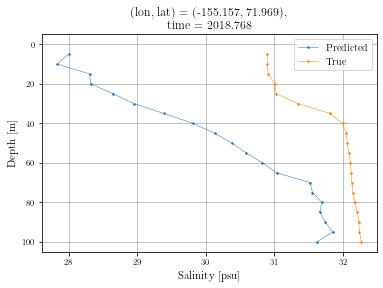

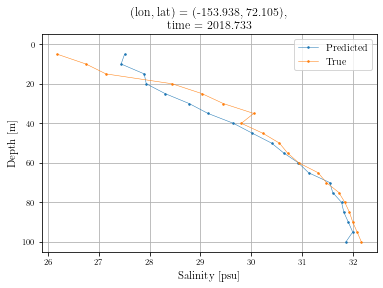

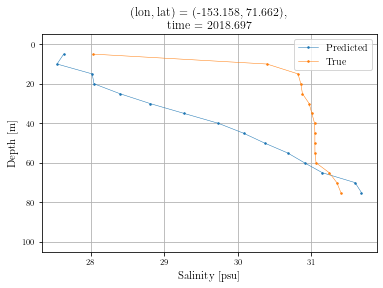

In [8]:
print("-"*10 + "Training" + "-"*10)
plots.show_plots(y_train_pred, y_train_true, train_depth, train_loader, named_scalers, 5)
print("-"*10 + "Validation" + "-"*10)
plots.show_plots(y_val_pred, y_val_true, val_depth, val_loader, named_scalers, 5)
print("-"*10 + "Testing" + "-"*10)
plots.show_plots(y_test_pred, y_test_true, test_depth, test_loader, named_scalers, 5)

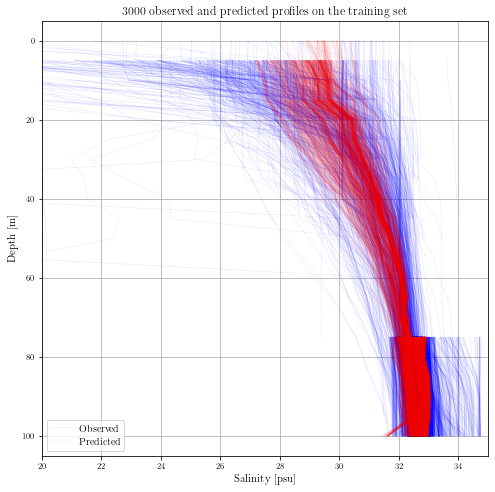

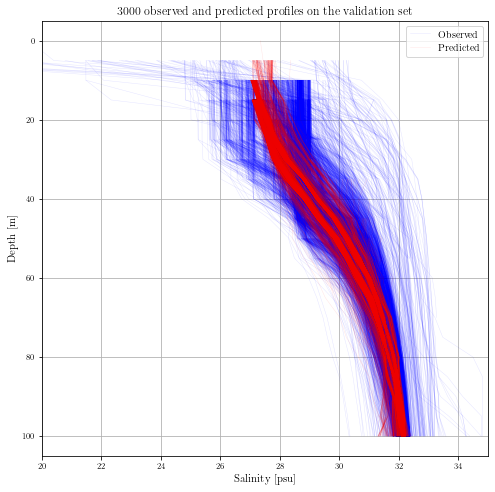

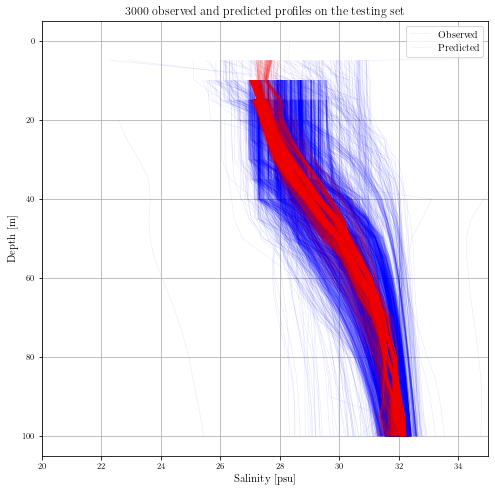

In [9]:
number_profiles = 3000
fig, ax = plt.subplots(figsize=(8,8))
plt.title(f"{number_profiles} observed and predicted profiles on the training set")
plots.show_all(y_train_pred, y_train_true, train_depth, train_loader, named_scalers, number_profiles, ax)
plt.show()
fig, ax = plt.subplots(figsize=(8,8))
plt.title(f"{number_profiles} observed and predicted profiles on the validation set")
plots.show_all(y_val_pred, y_val_true, val_depth, val_loader, named_scalers, number_profiles, ax)
plt.show()
fig, ax = plt.subplots(figsize=(8,8))
plt.title(f"{number_profiles} observed and predicted profiles on the testing set")
plots.show_all(y_test_pred, y_test_true, test_depth, test_loader, named_scalers, number_profiles, ax)
plt.show()

----------Training----------
<class 'shapely.geometry.polygon.Polygon'>


AttributeError: 'Polygon' object has no attribute 'geoms'

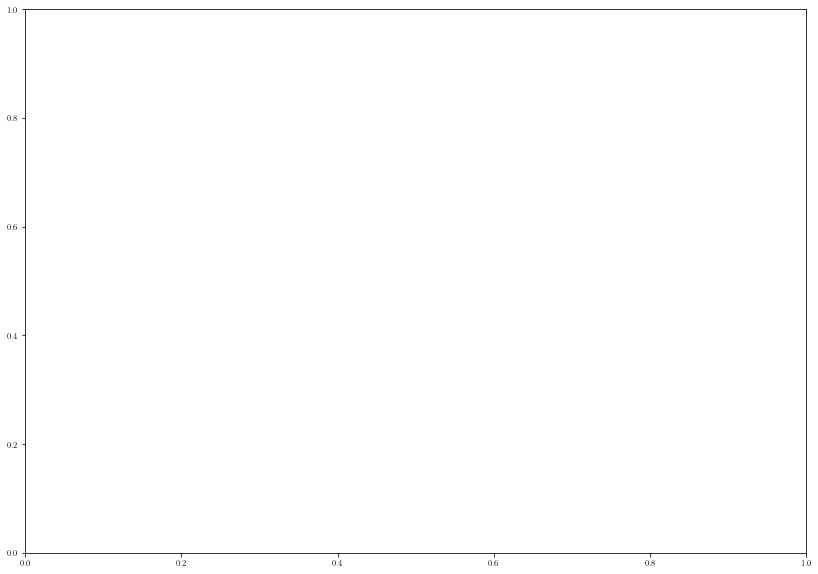

In [24]:
chosen_depth = 75 # Choose at which depth the cross should be in
xlim = [-160, -120] # Lon
ylim = [65, 85] # Lat
clim = [30, 33] # Colorbar
print("-"*10 + "Training" + "-"*10)
plots.plot_salinity_depth(y_train_true, chosen_depth, train_depth, train_loader, named_scalers, xlim, ylim, clim, False)
plots.plot_salinity_model_depth(y_train_pred, chosen_depth, train_depth, train_loader, named_scalers, xlim, ylim, clim, False)
print("-"*10 + "Validation" + "-"*10)
plots.plot_salinity_depth(y_val_true, chosen_depth, val_depth, val_loader, named_scalers, xlim, ylim, clim, False)
plots.plot_salinity_model_depth(y_val_pred, chosen_depth, val_depth, val_loader, named_scalers, xlim, ylim, clim, False)
print("-"*10 + "Testing" + "-"*10)
plots.plot_salinity_depth(y_test_true, chosen_depth, test_depth, test_loader, named_scalers, xlim, ylim, clim, False)
plots.plot_salinity_model_depth(y_test_pred, chosen_depth, test_depth, test_loader, named_scalers, xlim, ylim, clim, False)

----------Training----------


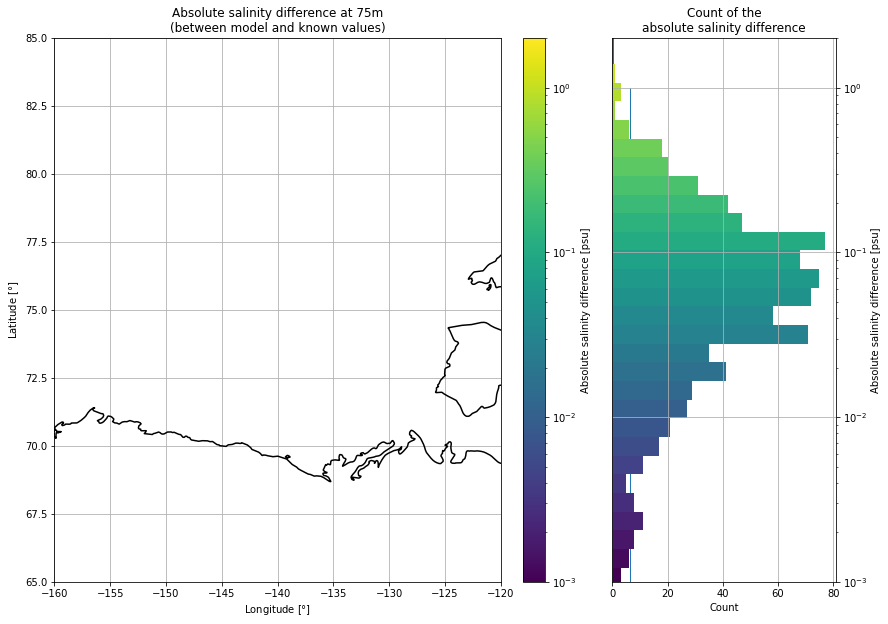

----------Validation----------


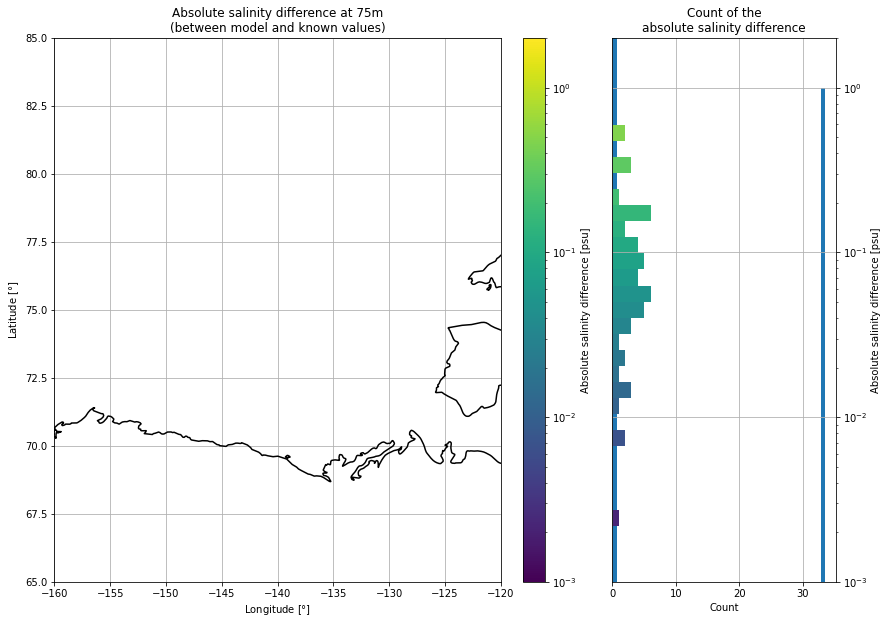

----------Testing----------


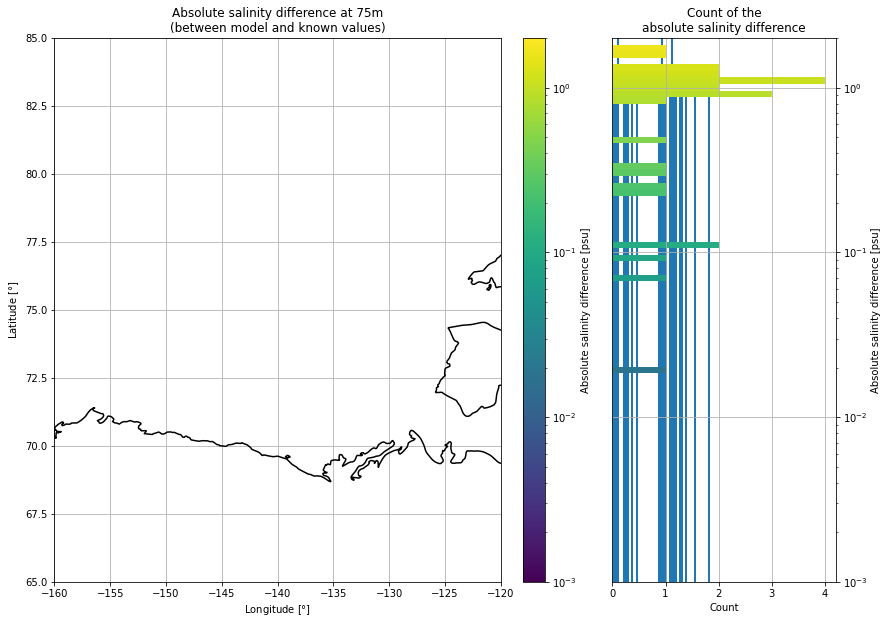

In [44]:
chosen_depth = 75 # Choose at which depth the cross should be in
xlim = [-160, -120] # Lon
ylim = [65, 85] # Lat
clim = [1e-3, 2] # Colorbar
print("-"*10 + "Training" + "-"*10)
plots.plot_different_salinity_depth(y_train_pred, y_train_true, chosen_depth, train_depth, train_loader, named_scalers, xlim, ylim, clim, True)
print("-"*10 + "Validation" + "-"*10)
plots.plot_different_salinity_depth(y_val_pred, y_val_true, chosen_depth, val_depth, val_loader, named_scalers, xlim, ylim, clim, True)
print("-"*10 + "Testing" + "-"*10)
plots.plot_different_salinity_depth(y_test_pred, y_test_true, chosen_depth, test_depth, test_loader, named_scalers, xlim, ylim, clim, True)

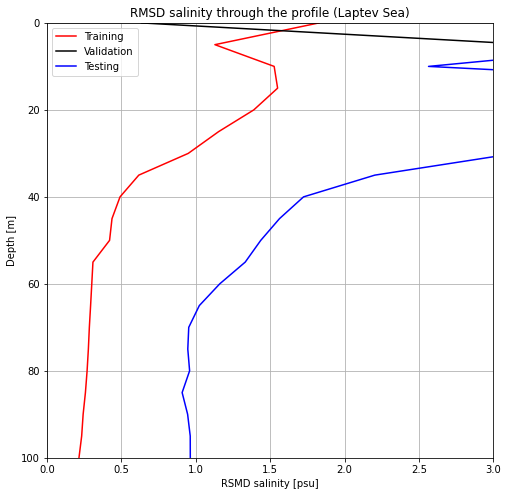

In [48]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plots.plot_error_depth(y_train_pred, y_train_true, train_depth, ax, 'Training', color='red')
ax = plots.plot_error_depth(y_val_pred, y_val_true, val_depth, ax, 'Validation', color='black')
ax = plots.plot_error_depth(y_test_pred, y_test_true, test_depth, ax, 'Testing', color='blue')
plt.legend()
plt.grid()
plt.ylim([100,0])
plt.xlim([0,3])
plt.title(f"RMSD salinity through the profile ({cfg.area.replace('_', ' ')})")
plt.ylabel("Depth [m]")
plt.xlabel("RSMD salinity [psu]")
plt.show()

## Processing of sss and sst (SMOS, GHRSST)

## sss

In [49]:
# Count number of valid datapoint in the chosen area
xlim = [-160, -120] # Lon
ylim = [65, 85] # Lar
data_points = []

for smos_chosen_idx in range(len(smos_time)):
    smos_chosen_time = smos_time[smos_chosen_idx]
    smos_chosen_sss = smos_sss[smos_chosen_idx].flatten()
    smos_remove = smos_chosen_sss != -999
    smos_chosen_lat = smos_lat[smos_chosen_idx].flatten()[smos_remove]
    smos_chosen_lon = smos_lon[smos_chosen_idx].flatten()[smos_remove]
    remove_lat_lon = (smos_chosen_lat >= ylim[0]) & (smos_chosen_lat <= ylim[1]) & (smos_chosen_lon >= xlim[0]) & (smos_chosen_lon <= xlim[1])
    
    data_points.append(len(smos_chosen_lat[remove_lat_lon]))

In [50]:
# Save the valid data for the chosen idx
smos_chosen_idx = np.argmax(data_points)
smos_chosen_time = smos_time[smos_chosen_idx]
smos_chosen_sss = smos_sss[smos_chosen_idx].flatten()
smos_remove = smos_chosen_sss != -999
smos_chosen_sss = smos_chosen_sss[smos_remove]
smos_chosen_lat = smos_lat[smos_chosen_idx].flatten()[smos_remove]
smos_chosen_lon = smos_lon[smos_chosen_idx].flatten()[smos_remove]

remove_lat_lon = (smos_chosen_lat >= ylim[0]) & (smos_chosen_lat <= ylim[1]) & (smos_chosen_lon >= xlim[0]) & (smos_chosen_lon <= xlim[1])

smos_chosen_lat = smos_chosen_lat[remove_lat_lon]
smos_chosen_lon = smos_chosen_lon[remove_lat_lon]
smos_chosen_sss = smos_chosen_sss[remove_lat_lon]

print(f"The chosen time is {smos_chosen_time:.2f}")

The chosen time is 2016.68


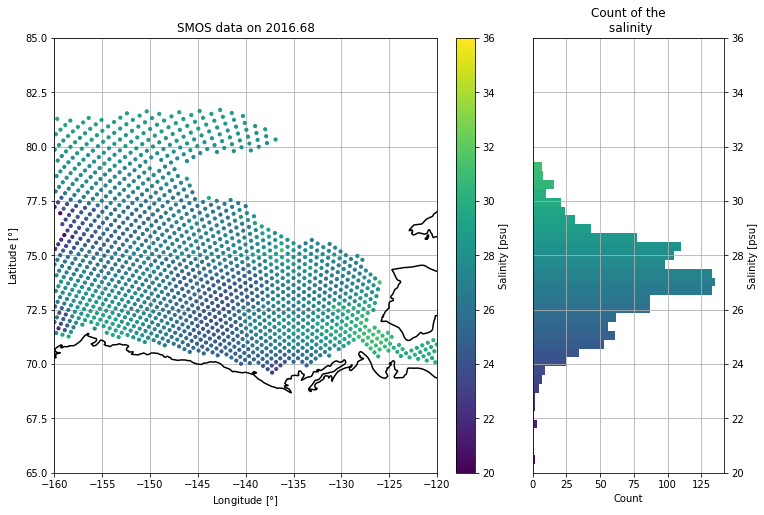

In [55]:
xlim = [-160, -120]
ylim = [65, 85]
clim = [20, 36]


fig, ax = plt.subplots(figsize=(12,8))
ax_main, ax_color, ax_hist, cbar = plots.plot_color_map(
    lat=smos_chosen_lat,
    lon=smos_chosen_lon,
    z=smos_chosen_sss,
    xlim=xlim,
    ylim=ylim,
    clim=clim,
    log_scale=False,
    ax=ax
)
ax.set_title(f"SMOS data on {smos_chosen_time:.2f}")
ax_main.set_xlabel(r"Longitude [$\degree$]")
ax_main.set_ylabel(r"Latitude [$\degree$]")
cbar.ax.set_ylabel('Salinity [psu]')
ax_hist.set_ylabel('Salinity [psu]')
ax_hist.set_xlabel('Count')
ax_hist.set_title("Count of the\n salinity")
plt.show()

### Interpolate sst to sss lat lon

In [102]:
grid_ghrrst_lat, grid_ghrrst_lon = np.meshgrid(ghrsst_lat, ghrsst_lon, indexing='ij')

In [103]:
xlim = [-165, -115]
ylim = [60, 89]

# Save the valid data for the chosen idx
ghrsst_chosen_idx = np.argmin(abs(ghrsst_fraction_time - smos_chosen_time))#np.argmax(data_points)
ghrsst_chosen_time = ghrsst_fraction_time[ghrsst_chosen_idx]
ghrsst_chosen_sst = ghrsst_sst[ghrsst_chosen_idx]
ghrsst_remove = ghrsst_chosen_sst >= 0


ghrsst_chosen_sst = ghrsst_chosen_sst[ghrsst_remove]
ghrsst_chosen_lat = grid_ghrrst_lat[ghrsst_remove]
ghrsst_chosen_lon = grid_ghrrst_lon[ghrsst_remove] - 360

remove_lat_lon = (ghrsst_chosen_lat >= ylim[0]) & (ghrsst_chosen_lat <= ylim[1]) & (ghrsst_chosen_lon >= xlim[0]) & (ghrsst_chosen_lon <= xlim[1])

ghrsst_chosen_lat = ghrsst_chosen_lat[remove_lat_lon]
ghrsst_chosen_lon = ghrsst_chosen_lon[remove_lat_lon]
ghrsst_chosen_sst = ghrsst_chosen_sst[remove_lat_lon]
print(f"The chosen time is {ghrsst_chosen_time:.2f}")


ghrsst_interpolate = LinearNDInterpolator(
    np.vstack([ghrsst_chosen_lat, ghrsst_chosen_lon]).T,
    ghrsst_chosen_sst
)
smos_chosen_sst = ghrsst_interpolate(smos_chosen_lat, smos_chosen_lon)


The chosen time is 2016.68


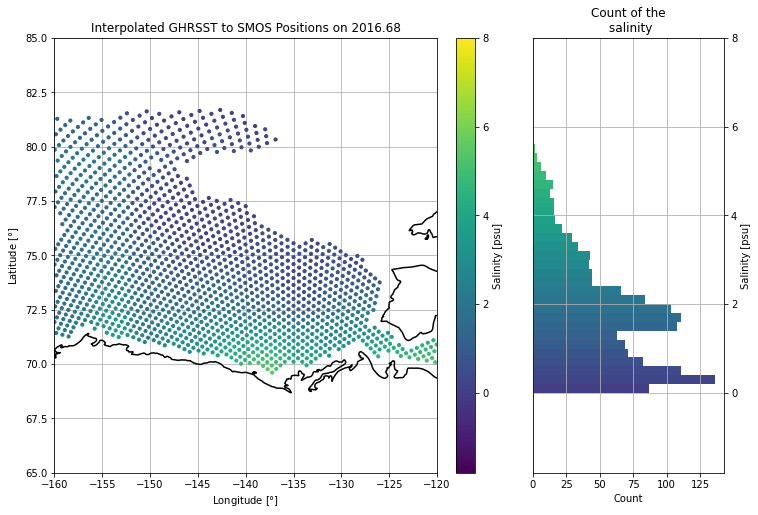

In [104]:
xlim = [-160, -120]
ylim = [65, 85]
clim = [-1.8, 8]
fig, ax = plt.subplots(figsize=(12,8))
ax_main, ax_color, ax_hist, cbar = plots.plot_color_map(
    lat=smos_chosen_lat,
    lon=smos_chosen_lon,
    z=smos_chosen_sst,
    xlim=xlim,
    ylim=ylim,
    clim=clim,
    log_scale=False,
    ax=ax
)
ax.set_title(f"Interpolated GHRSST to SMOS Positions on {smos_chosen_time:.2f}")
ax_main.set_xlabel(r"Longitude [$\degree$]")
ax_main.set_ylabel(r"Latitude [$\degree$]")
cbar.ax.set_ylabel('Salinity [psu]')
ax_hist.set_ylabel('Salinity [psu]')
ax_hist.set_xlabel('Count')
ax_hist.set_title("Count of the\n salinity")
plt.show()

### Predictions using smos and ghrsst

#### Inputs
\[lat, lon, year, decimal_year, sss, sst, starts_depth, Bathymetri\]

#### Outputs
\[salinity, temperatur\]

In [105]:
smos_features = [
    smos_chosen_lat,
    smos_chosen_lon,
    np.repeat(smos_chosen_time // 1, len(smos_chosen_sst)),
    np.repeat(smos_chosen_time % 1, len(smos_chosen_sst)),
    smos_chosen_sss,
    smos_chosen_sst,
    np.repeat(0, len(smos_chosen_sst)),
    torch_util.get_bathymetri(smos_chosen_lat, smos_chosen_lon, bathymetri_lat, bathymetri_lon, bathymetri_topography)
]
smos_scaled_features = []
for feature, key in zip(smos_features, named_scalers):
    smos_scaled_features.append(
        named_scalers[key](feature)
    )
smos_model_input = torch.tensor(np.vstack(smos_scaled_features)).T.cuda()

In [106]:
model.eval()
smos_out_model = model(smos_model_input.unsqueeze(1)).squeeze(1).detach().cpu().numpy()

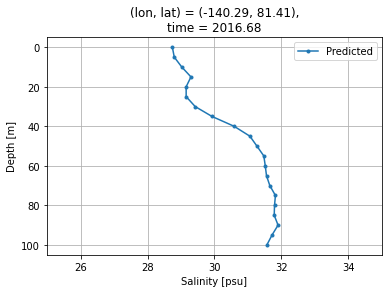

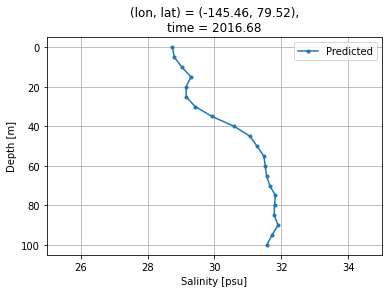

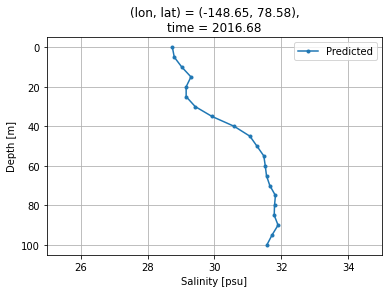

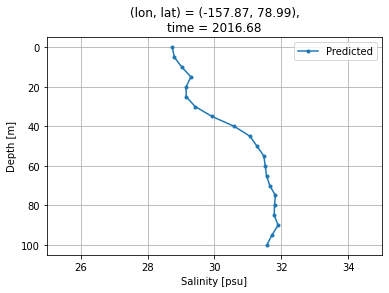

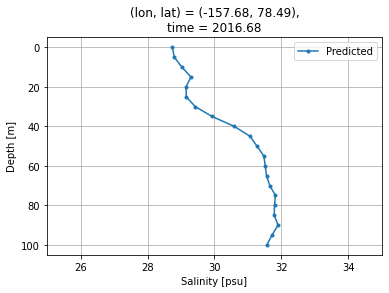

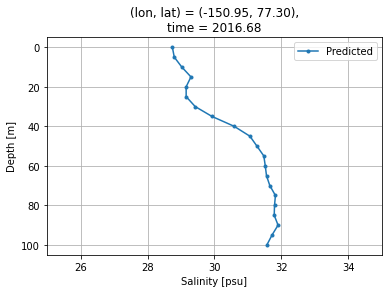

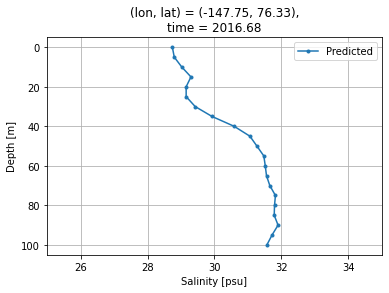

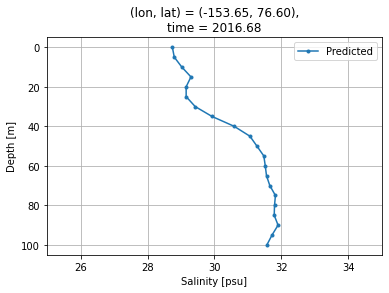

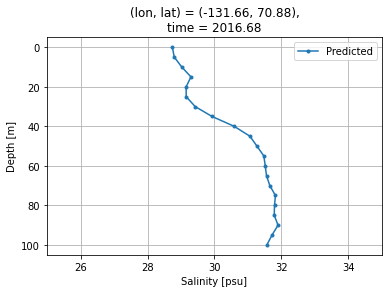

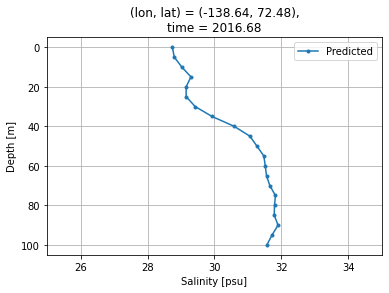

In [107]:
depth = np.arange(0,105,5)
for i in range(0,1000,100):
    cur_length = len(depth)
    predicted_values = smos_out_model[i,:]

    lat = named_scalers.lat.invert(smos_model_input[i,0])
    lon = named_scalers.lon.invert(smos_model_input[i,1])
    time = named_scalers.year.invert(smos_model_input[i,2]) + named_scalers.decimal_year.invert(smos_model_input[i,3])

    plt.figure()
    plt.title(f"(lon, lat) = ({lon.item():.2f}, {lat.item():.2f}),\ntime = {time.item():.2f}")
    plt.plot(named_scalers.salinity.invert(smos_out_model[0,:][::-1]), depth[::-1], label="Predicted", marker='.')
    plt.legend()
    plt.xlim([25,35])
    plt.ylim([105,-5])
    plt.grid()
    plt.xlabel("Salinity [psu]")
    plt.ylabel("Depth [m]")
    plt.show()

In [108]:
def to_date(fraction_date: float) -> datetime.datetime:
    """ Converts fraction date to timedate"""
    year = int(fraction_date)
    rem = fraction_date - year

    base = datetime.datetime(year, 1, 1)
    return base + datetime.timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)

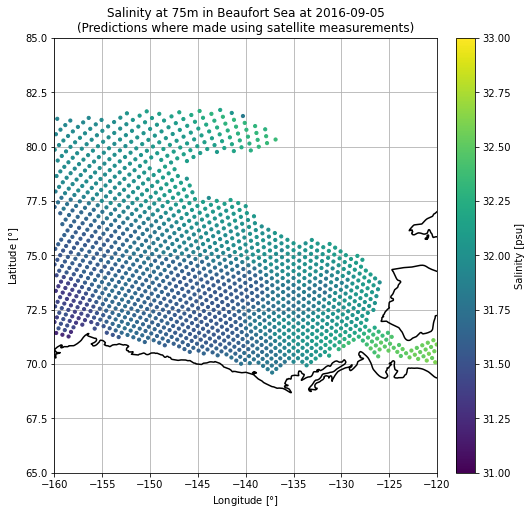

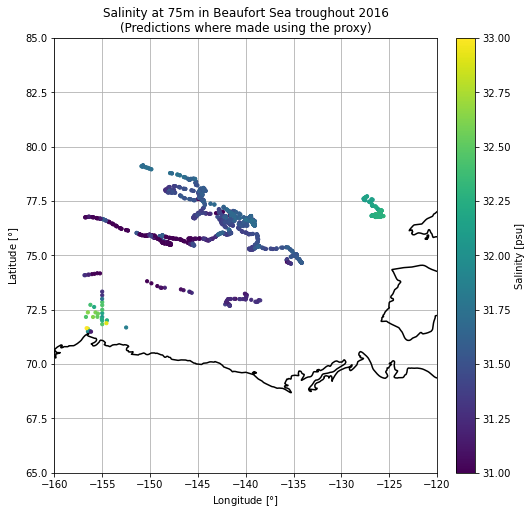

In [109]:
smos_chosen_time_title = to_date(smos_chosen_time)

chosen_depth = 75

depth_bool = np.arange(0,105,5) == chosen_depth

xlim = [-160, -120]
ylim = [65, 85]
clim = [31, 33]
xlim_hist = [0, 200]
log_scaled = False

fig, ax = plt.subplots(figsize=(12,8))
ax_main, ax_bar, ax_hist, cbar = plots.plot_color_map(
    lat=smos_chosen_lat,
    lon=smos_chosen_lon,
    z=named_scalers.salinity.invert(smos_out_model)[:,depth_bool].flatten(),
    xlim=xlim,
    ylim=ylim,
    clim=clim,
    log_scale=log_scaled,
    ax=ax
)
ax_hist.set_xlim(xlim_hist)
ax_main.set_title(f"Salinity at {chosen_depth}m in {cfg.area.replace('_',' ').title()} at {smos_chosen_time_title.date()}\n(Predictions where made using satellite measurements)")
ax_main.set_xlabel(r"Longitude [$\degree$]")
ax_main.set_ylabel(r"Latitude [$\degree$]")
cbar.ax.set_ylabel('Salinity [psu]')
ax_hist.set_ylabel('Salinity [psu]')
ax_hist.set_xlabel('Count')
ax_hist.set_title("Count of the salinity")
ax_hist.remove()
plt.show()



year_time_test = named_scalers.year.invert(test_loader.dataset[:][0][:,2])
decimal_time_test = named_scalers.decimal_year.invert(test_loader.dataset[:][0][:,3])
total_time_test = decimal_time_test + year_time_test
bool_time_range = year_time_test.long() == int(smos_chosen_time)
title_year = year_time_test.long()[bool_time_range][0].item()

lat_test, lon_test = named_scalers.lat.invert(test_loader.dataset[:][0][:,0]), named_scalers.lon.invert(test_loader.dataset[:][0][:,1])
legnths = np.array([len(d) for d in test_depth])
contains_depth = np.array([(d == chosen_depth).any() for d in test_depth])

bool_array_time = np.concatenate([[b]*l for b,l in zip(bool_time_range.cpu().numpy(), legnths)])



fig, ax = plt.subplots(figsize=(12,8))
ax_main, ax_bar, ax_hist, cbar = plots.plot_color_map(
    lat=lat_test[bool_time_range.cpu().numpy() & contains_depth].cpu().numpy(),
    lon=lon_test[bool_time_range.cpu().numpy() & contains_depth].cpu().numpy(),
    z=named_scalers.salinity.invert(y_test_true[((np.concatenate(test_depth) == chosen_depth) & bool_array_time)]).cpu().numpy(),
    xlim=xlim,
    ylim=ylim,
    clim=clim,
    log_scale=log_scaled,
    ax=ax
)
ax_hist.set_xlim(xlim_hist)
ax_main.set_title(f"Salinity at {chosen_depth}m in {cfg.area.replace('_',' ').title()} troughout {title_year:d}\n(Predictions where made using the proxy)")
ax_main.set_xlabel(r"Longitude [$\degree$]")
ax_main.set_ylabel(r"Latitude [$\degree$]")
cbar.ax.set_ylabel('Salinity [psu]')
ax_hist.set_ylabel('Salinity [psu]')
ax_hist.set_xlabel('Count')
ax_hist.set_title("Count of the salinity")
ax_hist.remove()
plt.show()

In [111]:
lat_chosen_test = lat_test[bool_time_range.cpu().numpy() & contains_depth].cpu().numpy()
lon_chosen_test = lon_test[bool_time_range.cpu().numpy() & contains_depth].cpu().numpy()
temperatur_chosen_depth = named_scalers.salinity.invert(y_test_true[((np.concatenate(test_depth) == chosen_depth) & bool_array_time)]).cpu().numpy()
temperatur_chosen_depth_pred = named_scalers.salinity.invert(y_test_pred.detach()[((np.concatenate(test_depth) == chosen_depth) & bool_array_time)]).cpu().numpy()

smos_non_scaled_temperatur = named_scalers.salinity.invert(smos_out_model)[:,depth_bool].flatten()

chosen_test_combined = np.vstack([lat_chosen_test, lon_chosen_test, temperatur_chosen_depth]).T
smos_combined = np.vstack([smos_chosen_lat, smos_chosen_lon, smos_non_scaled_temperatur]).T

In [112]:
distance, index = spatial.KDTree(smos_combined[:,0:2]).query(chosen_test_combined[:,0:2])
min_distance = np.array(distance) < 2
closest_points = smos_combined[index][min_distance]

diff_combined = chosen_test_combined[min_distance].copy()
diff_combined[:,2] = abs(closest_points[:,2] - diff_combined[:,2])

diff_combined_pred = chosen_test_combined[min_distance].copy()
diff_combined_pred[:,2] = abs(temperatur_chosen_depth[min_distance] - temperatur_chosen_depth_pred[min_distance])

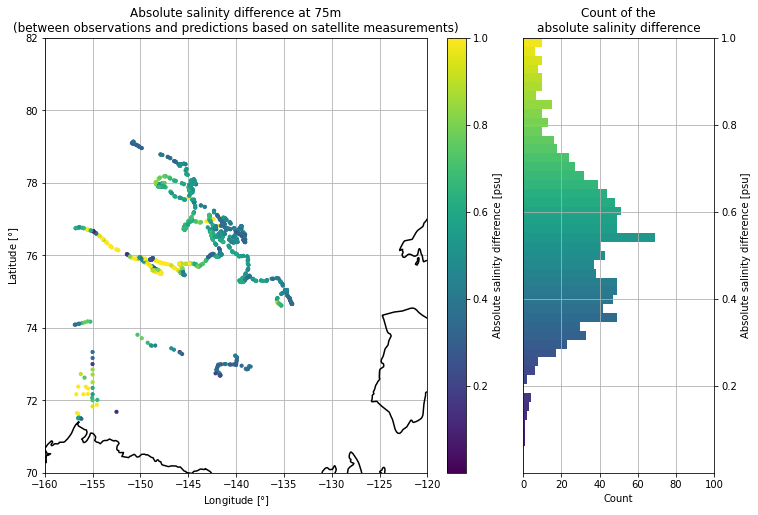

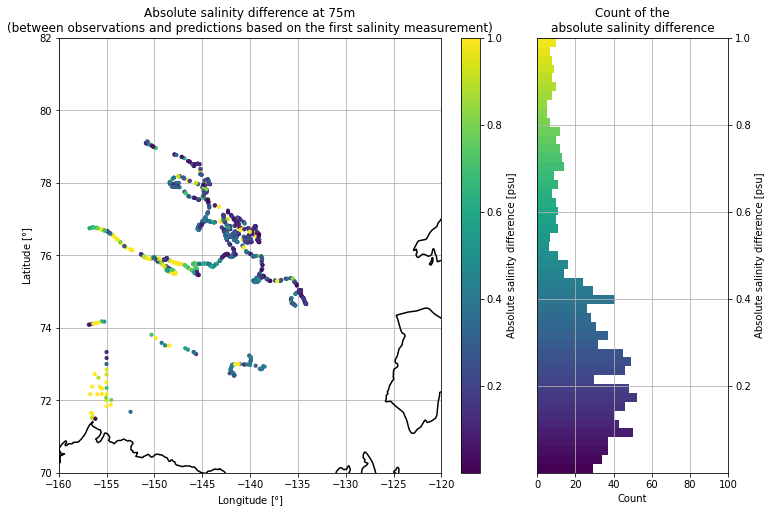

In [114]:
xlim = [-160, -120]
ylim = [70, 82]
clim = [1e-3, 1]
fig, ax = plt.subplots(figsize=(12,8))
ax_main, ax_bar, ax_hist, cbar = plots.plot_color_map(
    lat=diff_combined[:,0],
    lon=diff_combined[:,1],
    z=diff_combined[:,2],
    xlim=xlim,
    ylim=ylim,
    clim=clim,
    log_scale=False,
    ax=ax
)
ax_hist.set_xlim([0, 100])
ax_main.set_title(f"Absolute salinity difference at {chosen_depth}m\n(between observations and predictions based on satellite measurements)")
ax_main.set_xlabel(r"Longitude [$\degree$]")
ax_main.set_ylabel(r"Latitude [$\degree$]")
cbar.ax.set_ylabel('Absolute salinity difference [psu]')
ax_hist.set_ylabel('Absolute salinity difference [psu]')
ax_hist.set_xlabel('Count')
ax_hist.set_title("Count of the\nabsolute salinity difference")

plt.show()


fig, ax = plt.subplots(figsize=(12,8))
ax_main, ax_bar, ax_hist, cbar = plots.plot_color_map(
    lat=diff_combined_pred[:,0],
    lon=diff_combined_pred[:,1],
    z=diff_combined_pred[:,2],
    xlim=xlim,
    ylim=ylim,
    clim=clim,
    log_scale=False,
    ax=ax
)
ax_hist.set_xlim([0, 100])
ax_main.set_title(f"Absolute salinity difference at {chosen_depth}m\n(between observations and predictions based on the first salinity measurement)")
ax_main.set_xlabel(r"Longitude [$\degree$]")
ax_main.set_ylabel(r"Latitude [$\degree$]")
cbar.ax.set_ylabel('Absolute salinity difference [psu]')
ax_hist.set_ylabel('Absolute salinity difference [psu]')
ax_hist.set_xlabel('Count')
ax_hist.set_title("Count of the\nabsolute salinity difference")
plt.show()